In [1]:
# Regression Models
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures
#from tensorflow.keras.layers import LSTM, GRU, Dense
#from tensorflow.keras.models import Sequential
import torch.nn as nn
from prophet import Prophet

from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV

from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV,
StratifiedKFold, learning_curve, cross_val_predict, cross_validate,
permutation_test_score, validation_curve, StratifiedKFold, RandomizedSearchCV)

from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc)

In [2]:
df = pd.read_csv('15m_data.csv', engine='pyarrow', sep='\t')
df

,DateTime,Open,High,Low,Close,Volume,TickVolume
0,2025.07.15 20:30:00,22961.5,22968.9,22959.9,22966.8,0,962
1,2025.07.15 20:15:00,22946.8,22964.9,22930.9,22961.6,0,4332
2,2025.07.15 20:00:00,22940.5,22973.4,22938.5,22947.0,0,4669
3,2025.07.15 19:45:00,22978.5,22994.2,22925.4,22940.9,0,4441
4,2025.07.15 19:30:00,22987.5,23002.4,22968.4,22978.5,0,4098
...,...,...,...,...,...,...,...
201671,2016.11.15 07:30:00,4701.3,4702.4,4700.4,4701.6,0,310
201672,2016.11.15 07:15:00,4700.9,4702.9,4698.7,4701.3,0,450
201673,2016.11.15 07:00:00,4701.7,4703.1,4700.7,4701.3,0,280
201674,2016.11.15 06:45:00,4701.4,4703.1,4701.3,4701.6,0,276


In [3]:
#standardizing the columns 
df.columns = df.columns.str.lower()

In [4]:
#drop volume column 
df = df.drop(columns='volume', axis=1)

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201676 entries, 0 to 201675
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   datetime    201676 non-null  object 
 1   open        201676 non-null  float64
 2   high        201676 non-null  float64
 3   low         201676 non-null  float64
 4   close       201676 non-null  float64
 5   tickvolume  201676 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 22.3 MB


In [7]:
#checking for Null values
df.isna().sum()

datetime      0
open          0
high          0
low           0
close         0
tickvolume    0
dtype: int64

In [8]:
#changing dtype of datetime col
df['datetime'] = pd.to_datetime(df['datetime'])

In [115]:
#df.tail()

In [114]:
#df[(df['datetime'] >= '2025-01-01') & (df['datetime'] <= '2025-12-31')]

In [113]:
#df[df['datetime'] <= '2022-11-15 20:30:00']

In [9]:
df_2016 = df[(df['datetime'] >= '2016-01-01') & (df['datetime'] <= '2016-12-31')]
df_2017 = df[(df['datetime'] >= '2017-01-01') & (df['datetime'] <= '2017-12-31')]
df_2018 = df[(df['datetime'] >= '2018-01-01') & (df['datetime'] <= '2018-12-31')]
df_2019 = df[(df['datetime'] >= '2019-01-01') & (df['datetime'] <= '2019-12-31')]
df_2020 = df[(df['datetime'] >= '2020-01-01') & (df['datetime'] <= '2020-12-31')]
df_2021 = df[(df['datetime'] >= '2021-01-01') & (df['datetime'] <= '2021-12-31')]
df_2022 = df[(df['datetime'] >= '2022-01-01') & (df['datetime'] <= '2022-12-31')]
df_2023 = df[(df['datetime'] >= '2023-01-01') & (df['datetime'] <= '2023-12-31')]
df_2024 = df[(df['datetime'] >= '2024-01-01') & (df['datetime'] <= '2024-12-31')]
df_2025 = df[(df['datetime'] >= '2025-01-01') & (df['datetime'] <= '2025-12-31')]

In [ ]:
#setting datetime col to index
# df = df.set_index('datetime')

In [ ]:
#df = df.reset_index()

In [10]:
df.head()

,datetime,open,high,low,close,tickvolume
0,2025-07-15 20:30:00,22961.5,22968.9,22959.9,22966.8,962
1,2025-07-15 20:15:00,22946.8,22964.9,22930.9,22961.6,4332
2,2025-07-15 20:00:00,22940.5,22973.4,22938.5,22947.0,4669
3,2025-07-15 19:45:00,22978.5,22994.2,22925.4,22940.9,4441
4,2025-07-15 19:30:00,22987.5,23002.4,22968.4,22978.5,4098


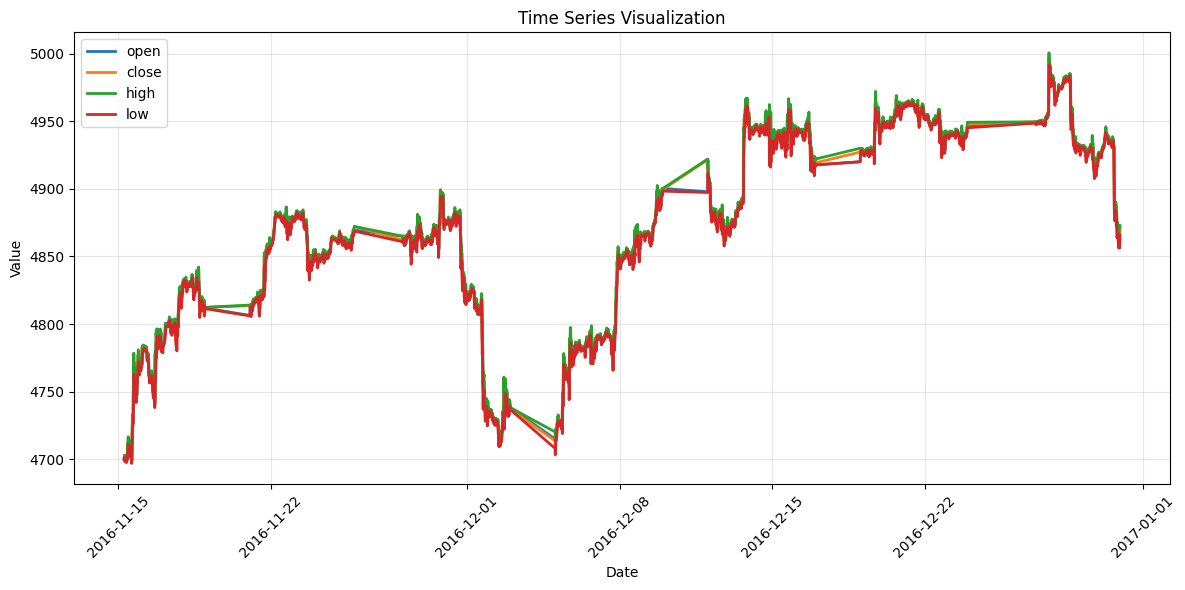

In [11]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2016['datetime'], df_2016[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2016['datetime'], df_2016[['open', 'close']], linewidth=2)
#plt.plot(df_2016['datetime'], df_2016[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2016[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2016[['open','close']]) #use only for open and close 
#plt.legend(df_2016[['high','low']]) #use only for high and low 
plt.show()

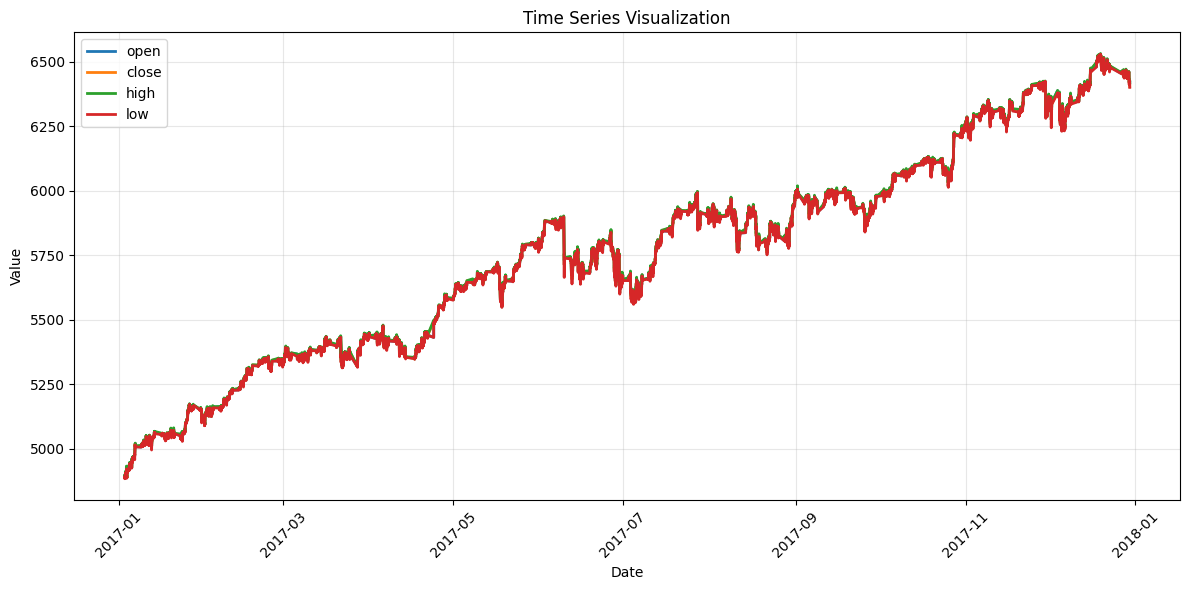

In [12]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2017['datetime'], df_2017[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2017['datetime'], df_2017[['open', 'close']], linewidth=2)
#plt.plot(df_2017['datetime'], df_2017[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2017[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2016[['open','close']]) #use only for open and close 
#plt.legend(df_2016[['high','low']]) #use only for high and low 
plt.show()

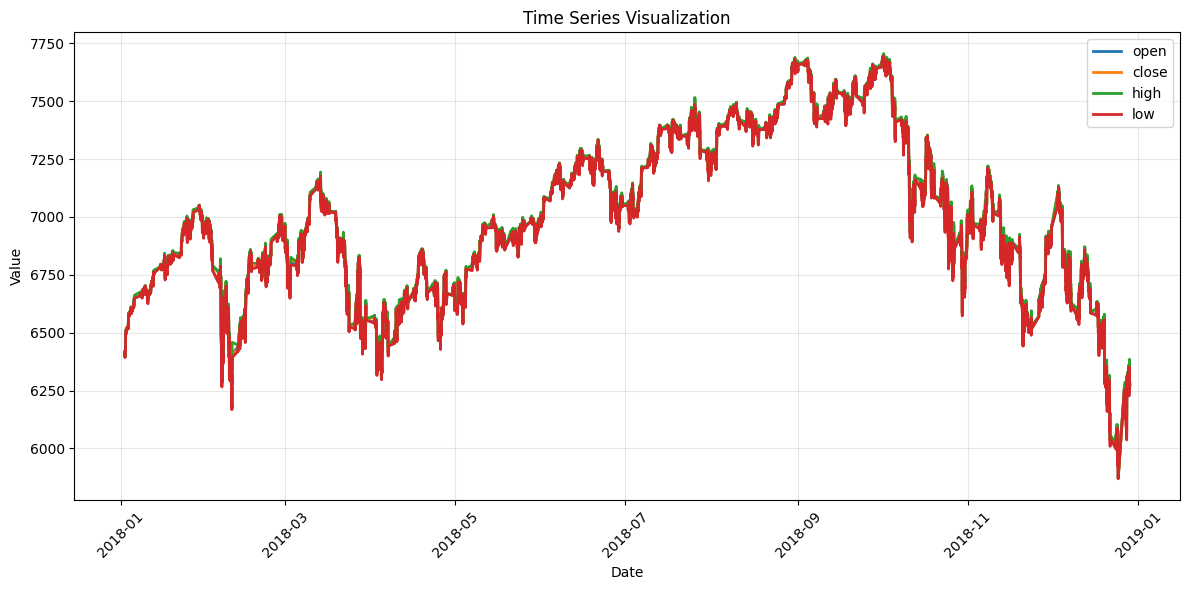

In [13]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2018['datetime'], df_2018[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2018['datetime'], df_2018[['open', 'close']], linewidth=2)
#plt.plot(df_2018['datetime'], df_2018[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2018[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2018[['open','close']]) #use only for open and close 
#plt.legend(df_2018[['high','low']]) #use only for high and low 
plt.show()

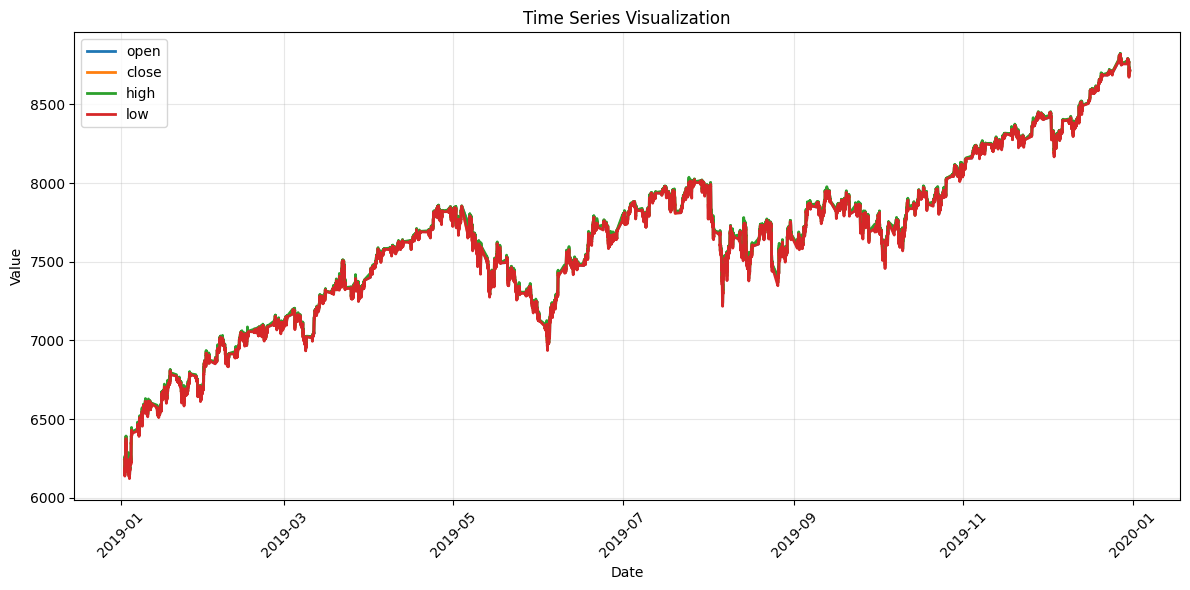

In [14]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2019['datetime'], df_2019[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2019['datetime'], df_2019[['open', 'close']], linewidth=2)
#plt.plot(df_2019['datetime'], df_2019[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2019[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2019[['open','close']]) #use only for open and close 
#plt.legend(df_2019[['high','low']]) #use only for high and low 
plt.show()

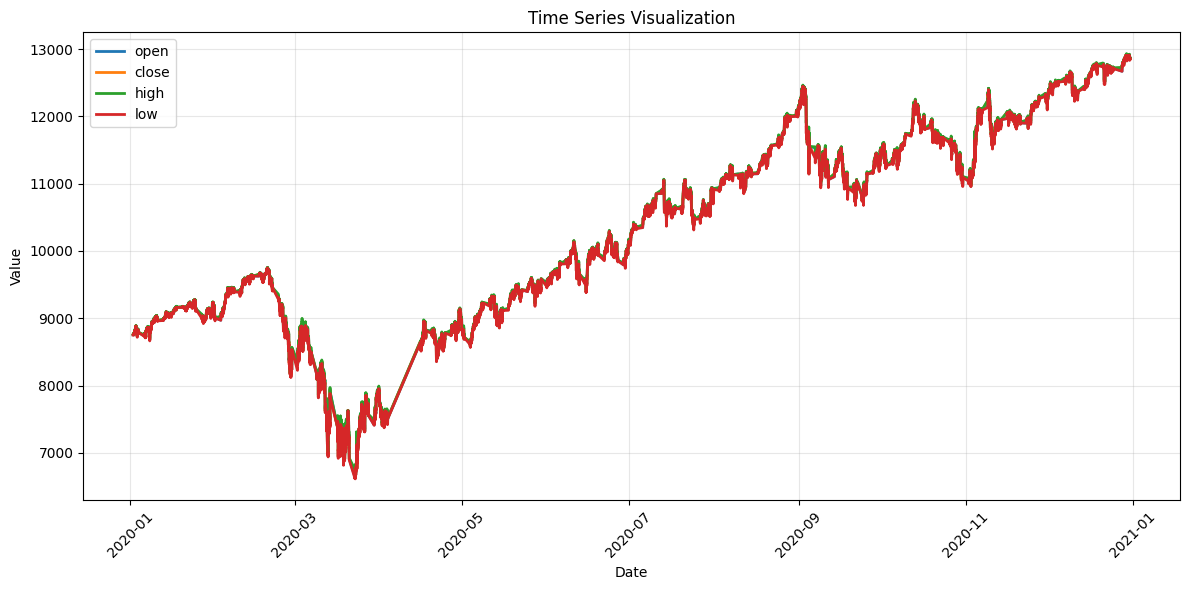

In [15]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2020['datetime'], df_2020[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2020['datetime'], df_2020[['open', 'close']], linewidth=2)
#plt.plot(df_2020['datetime'], df_2020[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2020[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2020[['open','close']]) #use only for open and close 
#plt.legend(df_2020[['high','low']]) #use only for high and low 
plt.show()

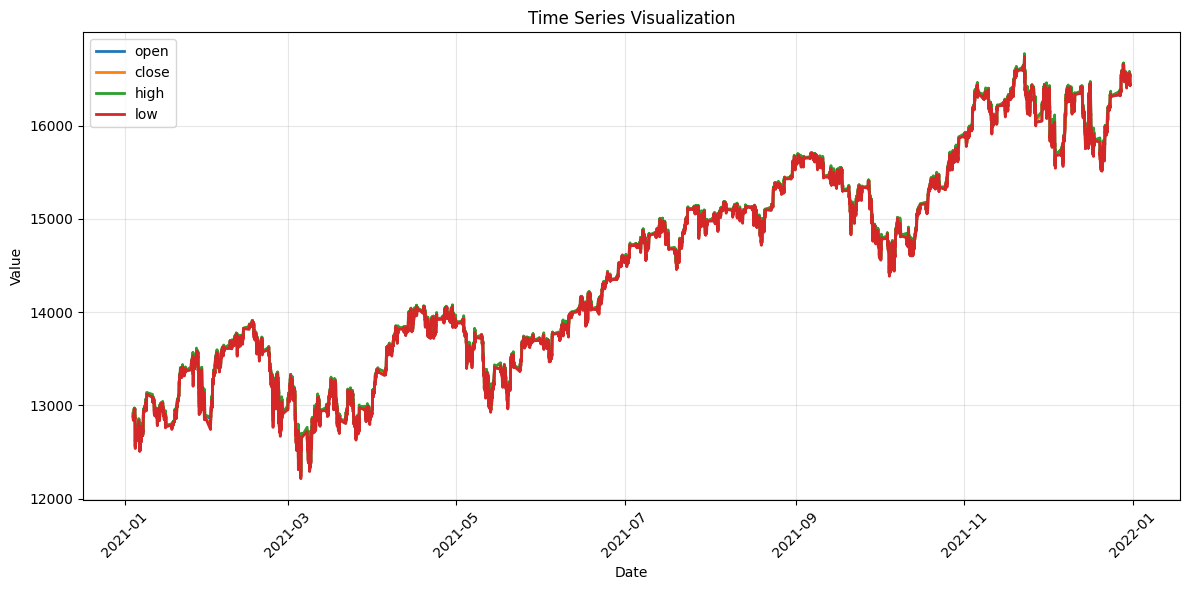

In [16]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2021['datetime'], df_2021[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2021['datetime'], df_2021[['open', 'close']], linewidth=2)
#plt.plot(df_2021['datetime'], df_2021[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2021[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2021[['open','close']]) #use only for open and close 
#plt.legend(df_2021[['high','low']]) #use only for high and low 
plt.show()

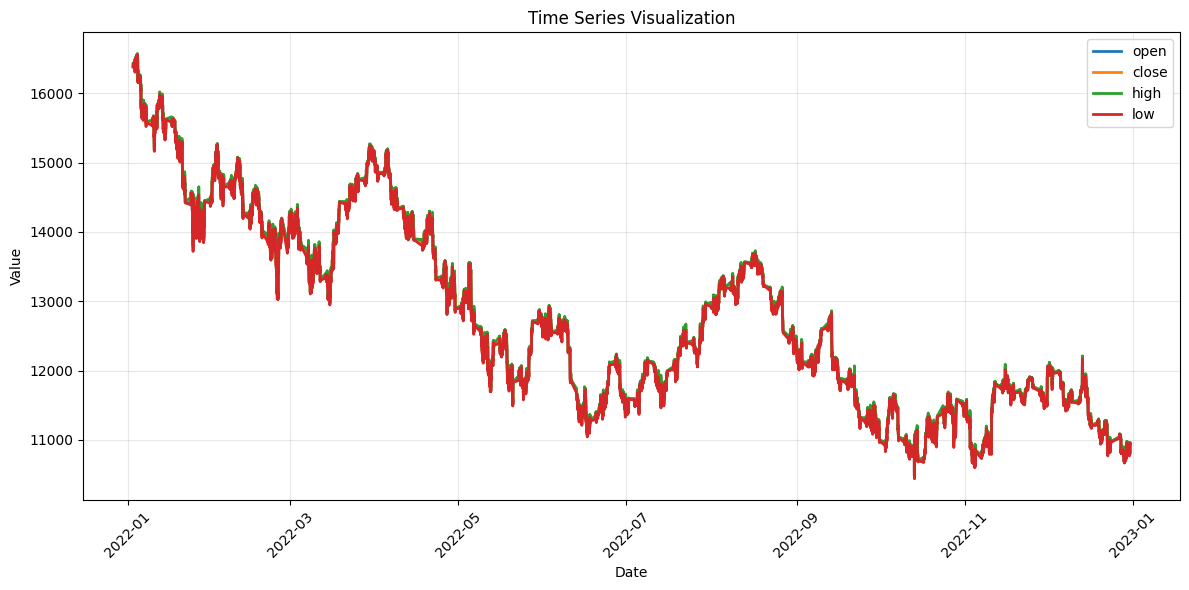

In [17]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2022['datetime'], df_2022[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2022['datetime'], df_2022[['open', 'close']], linewidth=2)
#plt.plot(df_2022['datetime'], df_2022[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2022[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2022[['open','close']]) #use only for open and close 
#plt.legend(df_2022[['high','low']]) #use only for high and low 
plt.show()

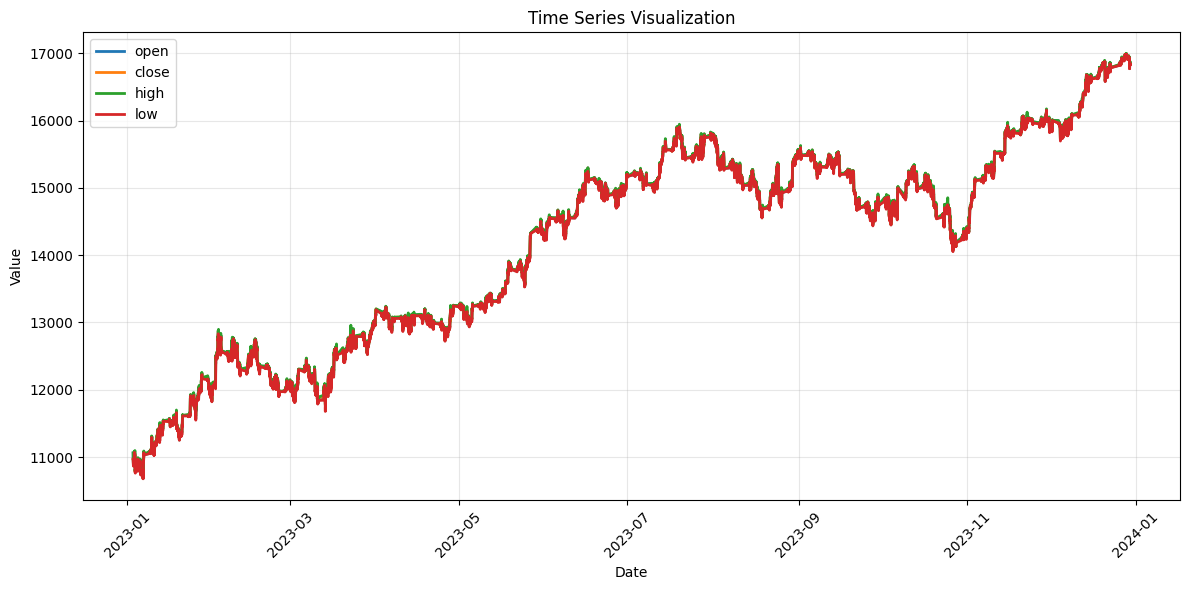

In [18]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2023['datetime'], df_2023[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2023['datetime'], df_2023[['open', 'close']], linewidth=2)
#plt.plot(df_2023['datetime'], df_2023[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2023[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2023[['open','close']]) #use only for open and close 
#plt.legend(df_2023[['high','low']]) #use only for high and low 
plt.show()

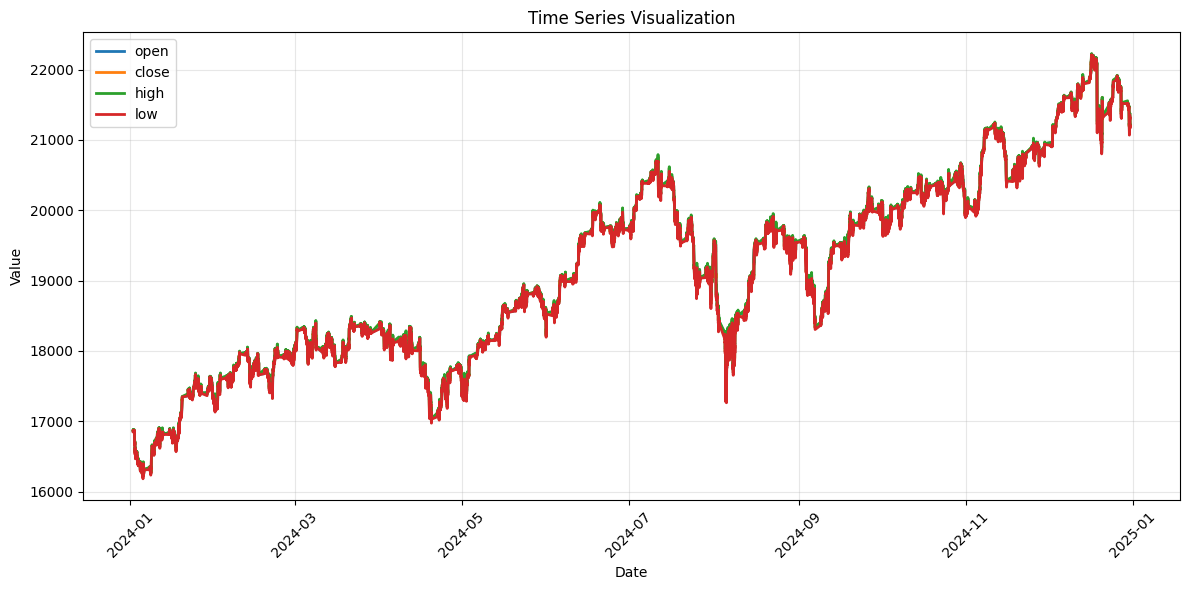

In [19]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2024['datetime'], df_2024[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2024['datetime'], df_2024[['open', 'close']], linewidth=2)
#plt.plot(df_2024['datetime'], df_2024[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2024[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2024[['open','close']]) #use only for open and close 
#plt.legend(df_2024[['high','low']]) #use only for high and low 
plt.show()

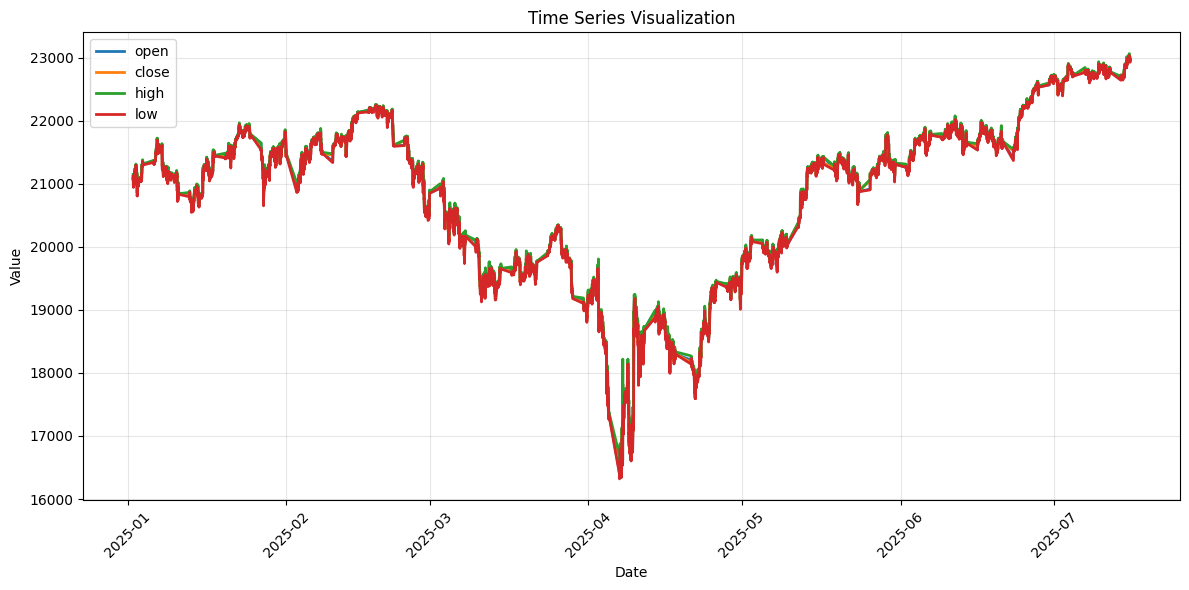

In [20]:
# Basic line plot
plt.figure(figsize=(12, 6))
plt.plot(df_2025['datetime'], df_2025[['open', 'close', 'high', 'low']], linewidth=2) #plot all at once
#plt.plot(df_2025['datetime'], df_2025[['open', 'close']], linewidth=2)
#plt.plot(df_2025['datetime'], df_2025[['high','low']], linewidth=2)
plt.title('Time Series Visualization')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(df_2025[['open','close','high','low']]) #use for all of them 
#plt.legend(df_2025[['open','close']]) #use only for open and close 
#plt.legend(df_2025[['high','low']]) #use only for high and low 
plt.show()

In [21]:
new_df = df.copy()

In [22]:
new_df

,datetime,open,high,low,close,tickvolume
0,2025-07-15 20:30:00,22961.5,22968.9,22959.9,22966.8,962
1,2025-07-15 20:15:00,22946.8,22964.9,22930.9,22961.6,4332
2,2025-07-15 20:00:00,22940.5,22973.4,22938.5,22947.0,4669
3,2025-07-15 19:45:00,22978.5,22994.2,22925.4,22940.9,4441
4,2025-07-15 19:30:00,22987.5,23002.4,22968.4,22978.5,4098
...,...,...,...,...,...,...
201671,2016-11-15 07:30:00,4701.3,4702.4,4700.4,4701.6,310
201672,2016-11-15 07:15:00,4700.9,4702.9,4698.7,4701.3,450
201673,2016-11-15 07:00:00,4701.7,4703.1,4700.7,4701.3,280
201674,2016-11-15 06:45:00,4701.4,4703.1,4701.3,4701.6,276
